# Aufgabenstellung

Es soll ein Model erstellt werden, welches einem Benutzer bei Eingabe einer Frage ähnliche, bereits vorhanden Fragen vorstellt.
Je präsizer der Bentuzer die Frage formuliert, umso präziser sollen auch die Vorhersagen sein.

# Lösung
## Betrachtung des Datensatzes
Der Datensatz beinhaltet neben den README-Dateien 3 CSV-Dateien

### Trainings-Datensatz
Der Trainingsdatensatz ist in der Datei 'training.csv' enthalten.
Der Datensatz enthält insgesamt 5 Attribute pro Datum.
Eine allgemeine 'id', eine 'qid1' & 'qid2' für die jeweilige Frage.
Schlussendlich folgen die beiden Fragen sowie die Spalte 'is_duplicate', bei welcher zwei Fragen mit gleicher Intention mit dem Label 1 markiert sind.

#### Aussortieren nicht benötigter Parameter

Die Attribute 'question1', 'question2' und 'is_duplicate' werden auf jedenfall benötigt, da in dieser die Fragen sowie das Klassiefizierungslabel enthalten sind

Im zu trainierenden Modell soll rein der textliche Inhalt der Fragen von Bedeutung sein. Aus diesem Grund werden beim Einlesen der Daten die Attribute 'id', 'qid1' & 'qid2' nicht mit geladen.

#### Vorverarbeitung der Daten
Im geladenen Dataframe werden die Datensätze entfernet, welche in einer der Attribute ein NaN-Value besitzen. Dies ist nötig, da aus diesen Datensätzen keinen sinnvollen Rückschlüsse gezogen werden können.

Außerdem werden Duplikate entfernt, da ein Training des selben Datensatzen nicht zur Verbesserung des Modelles beiträgt.


In [1]:
# https://www.kaggle.com/nkaps98/quora-question-pairs-glove-lstm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Multiply, Flatten, Dropout, Dense, LSTM
from sklearn.model_selection import train_test_split

df_train = pd.read_csv(
    "./fragen/train.csv",
    usecols = ['question1', 'question2', 'is_duplicate'],
    encoding = 'utf-8'
)

df_train.dropna(inplace=True)
df_train.head()

,question1,question2,is_duplicate
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Damit der Text präziser verarbeitet werden kann, werden außerdem alle Buchstaben in lowercase umgewandelt

In [2]:
df_train = df_train.applymap(lambda s: s.lower() if type(s) == str else s)

### Visualisieren der Trainingsdaten
#### Verteilung der Labels in den Trainingsdaten

Im folgenden wird die Verteilung der Label in den Trainingsdaten mit Hilfe eines Balkendiagrammes visualisiert.

Text(0.5, 1.0, 'Number of elements found in dataset')

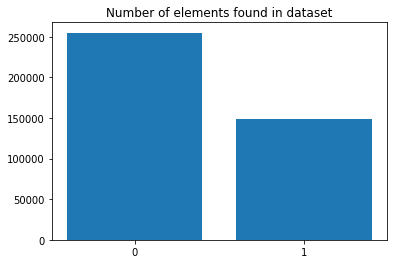

In [3]:
fig, ax = plt.subplots()
label_dist = df_train.is_duplicate.value_counts()

ax.bar([0,1],label_dist)
ax.set_xticks([0,1], labels=[0,1])
ax.set_title('Number of elements found in dataset')

#### Anzahl der Duplikate

In [4]:
print(df_train.duplicated(keep='first').sum())
df_train.groupby(df_train.columns.tolist(),as_index=False).size()

341


,question1,question2,is_duplicate,size
0,can i pay with a debit card on paypal?,can you transfer paypal funds onto a debit car...,0,1
1,does new york state have a flagship university?,how can the new york state be fixed?,0,1
2,failures haunt me all the time.how do i cope up?,what can help me cope up with my failure?,1,1
3,how do i make the time lapse images using an ...,how do i make time-lapse photography?,0,1
4,i didn't file a police report for a car accid...,why don't i get the money i paid for a year wo...,0,1
...,...,...,...,...
403941,你说我说中文会不会有人看得懂. what does this sentence mean?,what does this sentence mean?,0,1
403942,格局how to translate?,how do you translate this?,0,1
403943,格局how to translate?,"how would you translate ""一百回""?",0,1
403944,"黎权锋, help me make up an english name, thank yo...",would you want to help me come up with a name ...,0,1


In [5]:
label_dist[0] - label_dist[1]

105761

Es lässt sich beobachten, das circa 106k mehr Fragen mit dem Label 0, also sinnlich nicht verwandt, versehen sind. Dies kann bei dem trainierten Modell dazu führen, dass das Model zuverlässiger bei der Erkennung von nicht gleichen Fragen als bei gleichen Fragen ist.

## Einlesen der Testdaten

In [6]:
test_data_raw = pd.read_csv(
    "./fragen/test.csv",
    usecols= ['test_id', 'question1', 'question2'],
    encoding='utf-8'
)

test_data_raw = test_data_raw.applymap(lambda s: s.lower() if type(s) == str else s)
test_data_raw.dropna(inplace=True)
test_data_raw.head()

submission_data_raw = pd.read_csv(
    "./fragen/sample_submission.csv",
    usecols = ['test_id', 'is_duplicate']
)

submission_data_raw.dropna(inplace=True)
submission_data_raw.head()

/tmp/ipykernel_8293/1888995335.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data_raw = pd.read_csv(


,test_id,is_duplicate
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


### Zusammenführen der beiden Dataframes

In [7]:
test_data_merged_raw = test_data_raw.merge(submission_data_raw, left_on="test_id", right_on="test_id")

test_data_merged_raw.dropna(inplace=True)
test_data_merged_raw.drop_duplicates(inplace=True)
test_data_merged_raw.head()

test_data_merged_raw.is_duplicate.value_counts()

1    2345790
Name: is_duplicate, dtype: int64

### Kodieren der Fragen

In [8]:
target_test = test_data_merged_raw.pop('is_duplicate')

## Aufteilung der Trainingsdaten in Trainings- und Validierungsdaten
Vom Trainingsdatensatz wird die Label-Spalte 'is_duplicate' abgespaltet

Der Trainingsdatensatz wird in Trainings- und Validierungsdaten aufgeteilt.

20% des Trainingsdatensatzes werden als Validierungsdatensatz abgespalten.

Für ein reproduzierbares Ergebnis wurden bei der Aufteilung des Datensatzes ein festgelegter Seed verwendet.

In [9]:
df_train = df_train[df_train.is_duplicate == 1]
target = df_train.pop('is_duplicate')

xTrain, xValid, yTrain, yValid = train_test_split(df_train, target, test_size=0.2, random_state=35)
xTrain.head()

,question1,question2
221201,what is balance mutual fund and hybrid fund?,what is balanced mutual fund?
305525,who are notable angel investors in singapore?,who are the notable angel investors in singapore?
41913,if i take amphetamines drugs prescribed by a d...,if i take amphetamines drugs prescribed by a d...
73439,what is the best effective treatment for impot...,what is the best treatment for sexual impotence?
265591,how do i hack whatsapp messages without using ...,can i hack anyone’s whatsapp remotely?


## Erstellung eines Tokenizers

Um ein besseres Training zu ermöglichen, wird ein Tokenizer erstellt, welche die Wörter der Fragen einem Integer-Value zuordnet.
Der Tokenizer wird auf alle Fragen des nicht gesplitteten Trainingsdatensatzes angewandt.

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(df_train.question1.values) + list(df_train.question2.values))

## Kodierung  und Anpassung der Form der Fragen
Die Fragen der gesplitteten Datensätzen werden mittels des erstellten Tokenizer kodiert, sprich der String zu einem Array aus Integer werden umgewandelt.

Damit die Fragen auch alle das gleiche Format besitzen, wird das Array anschließend auf eine Länge von 40 gestreckt.

Positionen, welche nicht durch die Interger-Werte der Wörter des vorherigen Stringes gefüllt wurden, werden mit dem Wert 0 gefüllt.

In [11]:
def tokenizeQuestions(df_questions):
    tokenized_questions = tokenizer.texts_to_sequences(df_questions)
    return pad_sequences(tokenized_questions, maxlen = 36, padding = 'post')

In [12]:
q1_train = tokenizeQuestions(xTrain.question1)
q2_train = tokenizeQuestions(xTrain.question2)

q1_valid = tokenizeQuestions(xValid.question1)
q2_valid = tokenizeQuestions(xValid.question2)

q1_test = tokenizeQuestions(test_data_merged_raw.question1)
q2_test = tokenizeQuestions(test_data_merged_raw.question2)

In [13]:
word_index = tokenizer.word_index

#### Erstellung eines Dictionaries, welche später für das Finden von ähnlichen Fragen verwendet wird

In [14]:
completeQuestionsDict = np.concatenate((q1_train, q2_train, q1_valid, q2_valid))

## Erstellung des Modelles
Das Model beinhaltet 2 Untermodelle. Die Outputs dieser Modellen werden im Lauf des Modelles zusammengefügt und weiter verarbeitet.

Die 2 Untermodelle werden benötigt, da die 2 verschiedenen Fragen 2 Modell-Inputs darstellen und jeweils entsprechend (vor)verarbeitet werden müssen.

#### Erstellung einem vorgefertigeten GloVe Model für das Embedding-Layer
Bei der Aufgabenstellung bietet es sich an, für die Gewichtung des Embedding-Layers ein vorgefertigtes Modell zu nehmen.
In dieser Ausführung wird dazu das GloVe-Modell der Standard-Univerity verwendet.
Es enthält 42B-Tokens, und einen Umfang von 1.9M Wörtern
https://github.com/stanfordnlp/GloVe


### Erstellung der Input-Modelle
Da die beiden Untermodelle einen identischen Aufbau besitzen, wurde zur Erstellung dieser eine entsprechende Funktion erstellt


In [27]:
def build_model(vocab_size, embedding_dim, rnn_units):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length = 36, mask_zero=True),
        tf.keras.layers.LSTM(rnn_units, return_sequences=True),
        tf.keras.layers.Dense(36)
    ])
    return model

In [28]:
model = build_model(len(word_index)+1, 300, 512)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 36, 300)           9440400   
                                                                 
 lstm_3 (LSTM)               (None, 36, 512)           1665024   
                                                                 
 dense_2 (Dense)             (None, 36, 36)            18468     
                                                                 
Total params: 11,123,892
Trainable params: 11,123,892
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [30]:
model.fit(q1_train, q2_train, validation_data = (q1_valid, q2_valid), epochs = 5, batch_size = 2048)

Epoch 1/5
59/59 [==============================] - 11s 116ms/step - loss: nan - accuracy: 0.1210 - val_loss: nan - val_accuracy: 0.1231
Epoch 2/5
59/59 [==============================] - 6s 95ms/step - loss: nan - accuracy: 0.1226 - val_loss: nan - val_accuracy: 0.1231
Epoch 3/5
59/59 [==============================] - 6s 95ms/step - loss: nan - accuracy: 0.1226 - val_loss: nan - val_accuracy: 0.1231
Epoch 4/5
59/59 [==============================] - 6s 95ms/step - loss: nan - accuracy: 0.1226 - val_loss: nan - val_accuracy: 0.1231
Epoch 5/5
59/59 [==============================] - 6s 96ms/step - loss: nan - accuracy: 0.1226 - val_loss: nan - val_accuracy: 0.1231


## Speicherung des Modelles

In [ ]:
import os
if not os.path.exists('models'):
    os.mkdir('models')

hypermodel.save('models/kaggle.h5')

#### Laden des Modells, um ein erneutes Training zu verhindern

In [ ]:
model = tf.keras.models.load_model('./models/kaggle.h5')

Wie aus der gegebenen Accuracy des Test-Datenset hervorgeht, ist diese wesentliche schlechter als noch die Genauigkeit des Trainings- oder Validierungsdatenset.

In [ ]:
def getPrediction(question1, question2):
    test1 = tokenizer.texts_to_sequences(list([question1]))
    test1 = pad_sequences(test1, maxlen = 40, padding = 'post')
    test2 = tokenizer.texts_to_sequences(list([question2]))
    test2 = pad_sequences(test2, maxlen = 40, padding = 'post')
    return model.predict([test1, test2])
    #return 1 if hypermodel.predict([test1, test2]) / 1 >= 2 else 0


In [ ]:
getPrediction("What was your first sexual experience like?", "What was your first sexual experience like?")

# Implementierung in ein Frontend
## Erstellung einer Funktion, welche aus einer Benutzereingab 3 Fragen vorschlägt

In [ ]:
def getTopThreeQuestions(user_question, question_dict, model, tokenizer, threshold):
    found_questions = []
    encoded_user_question = tokenizer.texts_to_sequences(list([user_question]))
    encoded_user_question = pad_sequences(encoded_user_question, maxlen = 40, padding = 'post')
    for question in question_dict:
        if model.predict([encoded_user_question, np.array([question])]) >= threshold:
            decoded_question = tokenizer.sequences_to_texts([question])[0]
            print(decoded_question)
            found_questions.append(decoded_question)
            if len(found_questions) >= 3:
                break
    return found_questions

In [ ]:
test = getTopThreeQuestions("How can I be a good geologist?", completeQuestionsDict, model, tokenizer, 0.9)
test